In [1]:
import pyodbc
from numpy import vectorize
from numpy import NaN
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import BDay
from datetime import datetime
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from UliPlot.XLSX import auto_adjust_xlsx_column_width

# SQL

In [2]:
# Get GMLA list and GMLA system date
cklist_confirm_query = """ 
SELECT [projectSizeId]
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,[PROJECT_CATEGORY] as 'Segment'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      ,[status]
      /*,[kickOffMeetingDate]*/
      ,[baseOverDueDate] as 'actualCloseMeetingDate'
      ,[submitDate] as 'actualGMLASubmitDate'
      /*,[IsByPass]*/
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_CONFIRM]

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names and segment */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/

  WHERE [IsByPass] = '0'
"""

# Get design review date which sync PM system
project_schedule_query = """ 
SELECT [ProjectSizeId] as 'projectSizeId'
      /*
      ,[PROJECT_NAME]
      ,[T_GT_ProjectSchedule].[TASK_ID]
      */
      ,[DESC_OF_TASK]
      /*
      ,[T_GT_TaskBaseInfo].[Note]
      ,[IsPM]
      */
      ,DATEADD(DAY,-21,[Current_Date]) as 'estCloseMeetingDate'
      /* Design review -21 days */
  FROM [PR_WEB2].[dbo].[T_GT_ProjectSchedule]

  LEFT JOIN [PR_WEB2].[dbo].[T_GT_TaskBaseInfo] 
  ON [T_GT_ProjectSchedule].[TASK_ID] = [T_GT_TaskBaseInfo].TASK_ID

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on ProjectSizeId = [T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID
  
  WHERE DESC_OF_TASK
  IN ('Mechanical Design Review','Factory Prototype Design Review','Pilot Run Design Review')
"""

# Get OOB info in MP infomation
oob_mp_query = """
SELECT [T_MPC_CkListInfo].[PROJECT_SIZE_ID] as 'projectSizeId'
      ,[PROJECT_NAME] as 'Project_Name'
      /*,[T_MPC_CkListInfo].[MP_ID]
      ,[T_MPC_CkListInfo].[Item_ID]*/
      ,[Item_Name] as 'Description'
      ,[ORG_FILE_NAME] as 'MP_file'
      ,[Comment] as 'MP_Comment' /* User comment */
      ,[Status] /* If item is checked, 1=checked, 2=N/A */
      ,[UpdateUser]
      ,[UpdateTime]
  FROM [PR_WEB2].[dbo].[T_MPC_CkListInfo]

  LEFT JOIN [dbo].[T_PS_ProdSizeRelateInfo] 
  on [T_MPC_CkListInfo].PROJECT_SIZE_ID = [T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID

  LEFT JOIN [dbo].[T_MPC_RefFiles] on 
    [T_MPC_CkListInfo].PROJECT_SIZE_ID = [T_MPC_RefFiles].PROJECT_SIZE_ID
    AND [T_MPC_CkListInfo].MP_ID = [T_MPC_RefFiles].MP_ID
    AND [T_MPC_CkListInfo].Item_ID = [T_MPC_RefFiles].Item_ID
    /* Merge uploaded file name */

  where Item_Name like 'OOB%'
  /* Item_Name is 'Descroption' in MP information */
 
  ORDER BY [UpdateTime] DESC
"""

oob_pid_query = """
SELECT [T_PID_CkList].[PROJECT_SIZE_ID] as 'projectSizeId'
      ,[Category_Name] as 'Phase'
      ,[ORG_FILE_NAME] as 'PID_file'
      ,[COMMENT] as 'PID_Comment'
      /*,[T_PID_CkList].[MpType_ID]
      ,[T_PID_CkList].[Category_ID]
      ,[T_PID_CkList].[Item_ID]*/
      ,[Item_Name]
      ,[Status]
      ,[UpdateUser]
      ,[UpdateTime]
  FROM [PR_WEB2].[dbo].[T_PID_CkList]

  LEFT JOIN [T_PID_CkListFiles]
  ON ([T_PID_CkListFiles].[PROJECT_SIZE_ID] = [T_PID_CkList].[PROJECT_SIZE_ID]
  and [T_PID_CkListFiles].[MpType_ID] = [T_PID_CkList].[MpType_ID]
  and [T_PID_CkListFiles].[Category_ID] = [T_PID_CkList].[Category_ID]
  and [T_PID_CkListFiles].[Item_ID] = [T_PID_CkList].[Item_ID]
  and [T_PID_CkListFiles].[Frequency] = [T_PID_CkList].[Frequency]
  /* Frequency is duplicated phase count (e.g. Twice FP) */)
  where Item_Name = 'OOB planning readiness' and ORG_FILE_NAME is not NULL
"""

In [3]:
connection_string = "DRIVER={SQL Server};SERVER=T1-PE-SUPPORT;DATABASE=PR_WEB2;UID=pimes2;PWD=LhZEv9JtGsZNX"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

cklist_confirm = pd.read_sql(cklist_confirm_query, engine)
project_schedule = pd.read_sql(project_schedule_query, engine, parse_dates='estCloseMeetingDate')
oob_mp = pd.read_sql(oob_mp_query, engine)
oob_pid = pd.read_sql(oob_pid_query, engine)

# cklist_confirm

In [4]:
cklist_confirm.loc[cklist_confirm.actualCloseMeetingDate.str.startswith('0001-01', na=False),'actualCloseMeetingDate'] = None

In [5]:
cklist_confirm.actualCloseMeetingDate = pd.to_datetime(cklist_confirm.actualCloseMeetingDate, utc=True).dt.tz_convert('Asia/Taipei')
cklist_confirm.actualGMLASubmitDate = pd.to_datetime(cklist_confirm.actualGMLASubmitDate,utc=True).dt.tz_convert('Asia/Taipei')
cklist_confirm.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualCloseMeetingDate,actualGMLASubmitDate
0,766,GAD 13,Aviation,GMLA1,0,NaT,NaT
1,766,GAD 13,Aviation,GMLA2,0,NaT,NaT
2,766,GAD 13,Aviation,GMLA3,0,NaT,NaT
3,909,One Battery Bike Project,Fitness,GMLA3,1,2021-02-05 00:00:00+08:00,2021-03-04 15:19:42.207827800+08:00
4,936,Edge 1040,Fitness,GMLA1,1,2021-02-05 00:00:00+08:00,2021-02-19 17:29:48.395736400+08:00


In [6]:
#Project id 1124 is aborted
cklist_confirm = cklist_confirm[cklist_confirm.projectSizeId != 1124]

Merge project_schedule

In [7]:
project_schedule.estCloseMeetingDate = project_schedule.estCloseMeetingDate.dt.tz_convert('Asia/Taipei')

In [8]:
project_schedule['Phase'] = project_schedule.DESC_OF_TASK.map(
    {'Mechanical Design Review':'GMLA1','Factory Prototype Design Review':'GMLA2','Pilot Run Design Review':'GMLA3'})
project_schedule.drop_duplicates(subset=['projectSizeId','Phase'], inplace=True)
# Some project have multi-design review date in PMsystem

In [9]:
overall = pd.merge(left=cklist_confirm, right=project_schedule, how='left', on=['projectSizeId','Phase'])
overall.drop('DESC_OF_TASK', axis=1, inplace=True)

In [10]:
def mergeCloseMeeting(actualCloseMeetingDate, estCloseMeetingDate):
    if actualCloseMeetingDate is pd.NaT:
        return estCloseMeetingDate
    else:
        return actualCloseMeetingDate
overall['mergedCloseMeetingDate'] = vectorize(mergeCloseMeeting)(overall.actualCloseMeetingDate, overall.estCloseMeetingDate)
#overall['mergedCloseMeetingDate'] = overall[['actualCloseMeetingDate','estCloseMeetingDate']].apply(lambda overall : mergeCloseMeeting(overall['actualCloseMeetingDate'], overall['estCloseMeetingDate']),axis=1)

In [11]:
overall.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualCloseMeetingDate,actualGMLASubmitDate,estCloseMeetingDate,mergedCloseMeetingDate
0,766,GAD 13,Aviation,GMLA1,0,NaT,NaT,NaT,NaT
1,766,GAD 13,Aviation,GMLA2,0,NaT,NaT,NaT,NaT
2,766,GAD 13,Aviation,GMLA3,0,NaT,NaT,NaT,NaT
3,909,One Battery Bike Project,Fitness,GMLA3,1,2021-02-05 00:00:00+08:00,2021-03-04 15:19:42.207827800+08:00,2021-07-13 00:00:00+08:00,2021-02-05 00:00:00+08:00
4,936,Edge 1040,Fitness,GMLA1,1,2021-02-05 00:00:00+08:00,2021-02-19 17:29:48.395736400+08:00,2020-10-13 00:00:00+08:00,2021-02-05 00:00:00+08:00


In [12]:
overall['targetGMLASubmitDate'] = (overall.mergedCloseMeetingDate + BDay(8)).dt.date
overall.iloc[:,5:] = overall.iloc[:,5:].apply(lambda time: pd.to_datetime(time).dt.date)
overall.status = overall.status.map({1:'Complete',0:'Incomplete'})

In [13]:
overall.drop(['actualCloseMeetingDate','estCloseMeetingDate','mergedCloseMeetingDate'],axis=1, inplace=True)

In [14]:
overall.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualGMLASubmitDate,targetGMLASubmitDate
0,766,GAD 13,Aviation,GMLA1,Incomplete,NaT,NaT
1,766,GAD 13,Aviation,GMLA2,Incomplete,NaT,NaT
2,766,GAD 13,Aviation,GMLA3,Incomplete,NaT,NaT
3,909,One Battery Bike Project,Fitness,GMLA3,Complete,2021-03-04,2021-02-17
4,936,Edge 1040,Fitness,GMLA1,Complete,2021-02-19,2021-02-17


# OOB from MP infomation

Merge comment from oob_mp

In [15]:
oob_mp_group = oob_mp.groupby(['projectSizeId','Project_Name'])['MP_file'].count().to_frame().reset_index()
oob_mp_group.rename(columns={'MP_file':'MP_file_count'},inplace=True)
oob_mp_group.head()

,projectSizeId,Project_Name,MP_file_count
0,766,GAD 13,0
1,767,OnDeck (Telematics),0
2,768,USB SD-Card Reader,0
3,769,Striker Cast,0
4,770,Rally XC200/100,0


Merge OOB from MP to overall

In [16]:
overall_oob_mp = pd.merge(left=overall, right=oob_mp_group, how='left',left_on=['projectSizeId','Project_Name'], right_on=['projectSizeId','Project_Name'])
overall_oob_mp.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualGMLASubmitDate,targetGMLASubmitDate,MP_file_count
0,766,GAD 13,Aviation,GMLA1,Incomplete,NaT,NaT,0.0
1,766,GAD 13,Aviation,GMLA2,Incomplete,NaT,NaT,0.0
2,766,GAD 13,Aviation,GMLA3,Incomplete,NaT,NaT,0.0
3,909,One Battery Bike Project,Fitness,GMLA3,Complete,2021-03-04,2021-02-17,0.0
4,936,Edge 1040,Fitness,GMLA1,Complete,2021-02-19,2021-02-17,0.0


Merge comment from oob_mp to overall_oob_mp

In [17]:
oob_mp['MP_Comment'] = oob_mp['MP_Comment'].str.replace('</p>','')
oob_mp['MP_Comment'] = oob_mp['MP_Comment'].str.replace('<p>','')
oob_mp['MP_Comment'] = oob_mp['MP_Comment'].str.replace('\n','')

In [18]:
#Merge comment from oob_mp. Need to drop_duplicates since multi-files can be uploaded but one comment only
overall_oob_mp = pd.merge(left=overall_oob_mp, right=oob_mp[['projectSizeId','MP_Comment']].drop_duplicates(),left_on=['projectSizeId'], right_on=['projectSizeId'], how='left')

In [19]:
overall_oob_mp[overall_oob_mp.Project_Name == 'EPIX PRO (Gen 2) 51mm']

,projectSizeId,Project_Name,Segment,Phase,status,actualGMLASubmitDate,targetGMLASubmitDate,MP_file_count,MP_Comment
601,1094,EPIX PRO (Gen 2) 51mm,Outdoor,GMLA1,Complete,2022-07-22,2022-07-22,2.0,"ALS, AOD, ECG, Flashlight"
602,1094,EPIX PRO (Gen 2) 51mm,Outdoor,GMLA2,Complete,2022-11-07,2022-11-07,2.0,"ALS, AOD, ECG, Flashlight"
603,1094,EPIX PRO (Gen 2) 51mm,Outdoor,GMLA3,Incomplete,NaT,2023-02-20,2.0,"ALS, AOD, ECG, Flashlight"


# OOB from PID checklist

In [20]:
oob_pid.Phase = oob_pid.Phase.map({'Factory Prototype Close':'GMLA2','Pilot Run Close':'GMLA3'})

In [21]:
oob_pid.sort_values(['projectSizeId','UpdateTime'], ascending=True, inplace=True)

Merge OOB from PID to overall

In [22]:
oob_pid_group = oob_pid.groupby(['projectSizeId','Phase'])['PID_file'].count().to_frame().reset_index()
oob_pid_group.rename(columns={'PID_file':'PID_file_count'}, inplace=True)
oob_pid_group.head()

,projectSizeId,Phase,PID_file_count
0,961,GMLA2,2
1,962,GMLA2,2
2,1018,GMLA3,2
3,1036,GMLA2,1
4,1041,GMLA3,2


Merge comment from oob_pid

In [23]:
oob_pid.PID_Comment = oob_pid.PID_Comment.str.replace('<p>','')
oob_pid.PID_Comment = oob_pid.PID_Comment.str.replace('</p>','')
oob_pid.PID_Comment = oob_pid.PID_Comment.str.replace('\n','')

In [24]:
overall_oob_mp_pid = pd.merge(left=overall_oob_mp, right=oob_pid_group, how='left',left_on=['projectSizeId','Phase'], right_on=['projectSizeId','Phase']).sort_values('actualGMLASubmitDate', ascending=True)
#Merge comment from oob_pid. Need to drop_duplicates since multi-files can be uploaded but one comment only
overall_oob_mp_pid = pd.merge(left=overall_oob_mp_pid, right=oob_pid[['projectSizeId','Phase','PID_Comment']].drop_duplicates(), how='left',left_on=['projectSizeId','Phase'], right_on=['projectSizeId','Phase'])

overall_oob_mp_pid = overall_oob_mp_pid[overall_oob_mp_pid.Phase.isin(['GMLA2','GMLA3'])]
overall_oob_mp_pid = overall_oob_mp_pid[~overall_oob_mp_pid.Segment.isin(['OEM Auto','Aviation'])]

In [25]:
overall_oob_mp_pid.MP_file_count.fillna(0, inplace=True)
overall_oob_mp_pid.PID_file_count.fillna(0, inplace=True)
overall_oob_mp_pid['PID+MP_count'] = (overall_oob_mp_pid.MP_file_count + overall_oob_mp_pid.PID_file_count)

In [26]:
overall_oob_mp_pid.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualGMLASubmitDate,targetGMLASubmitDate,MP_file_count,MP_Comment,PID_file_count,PID_Comment,PID+MP_count
0,970,Approach G12,Outdoor,GMLA2,Complete,2020-12-25,2020-12-31,0.0,,0.0,NaN,0.0
1,870,Forerunner 945 LTE,Fitness,GMLA3,Complete,2020-12-28,2020-12-28,0.0,,0.0,NaN,0.0
2,954,Dash Cam Mini 2,Automotive,GMLA3,Complete,2020-12-28,2020-12-21,0.0,,0.0,NaN,0.0
3,917,Dash Cam 47 / 57 / 67W,Automotive,GMLA3,Complete,2020-12-28,2020-12-24,0.0,,0.0,NaN,0.0
4,959,fenix 7S,Outdoor,GMLA2,Complete,2020-12-28,2021-01-04,0.0,,0.0,NaN,0.0


In [27]:
# GMLA2 should upload 1 or more files; GMLA3 should 2 or more
def judgement(phase, totalCount):
    if (phase == 'GMLA2') & (totalCount >= 1):
        return True
    elif (phase == 'GMLA3') & (totalCount >= 2):
        return True
    else:
        return False

In [28]:
overall_oob_mp_pid['judgement'] = vectorize(judgement)(overall_oob_mp_pid['Phase'],overall_oob_mp_pid['PID+MP_count'])

In [29]:
def comment(MP, PID):
    if (MP is not NaN) & (PID is NaN):
        return MP
    elif (MP is NaN) & (PID is not NaN):
        return PID
    elif (MP is NaN) & (PID is NaN):
        return NaN
overall_oob_mp_pid['Comment'] = vectorize(comment)(overall_oob_mp_pid.MP_Comment, overall_oob_mp_pid.PID_Comment)

# New feature

In [30]:
feature = overall_oob_mp_pid[['Project_Name','actualGMLASubmitDate','Comment']].copy()

In [31]:
feature.actualGMLASubmitDate = pd.to_datetime(feature.actualGMLASubmitDate)
feature = feature[feature.actualGMLASubmitDate > '2022-10-01']

In [32]:
feature

,Project_Name,actualGMLASubmitDate,Comment
227,"vivomove Trend (previously ""4"")",2022-10-14,None
228,BlueNET Switch,2022-10-20,LED
229,BlueNET Gateway,2022-10-20,LED
230,EPIX PRO (Gen 2) 42mm,2022-10-24,"ALS, AOD, ECG, Flashlight"
232,EPIX PRO (Gen 2) 47mm,2022-10-31,"ALS, AOD, ECG, Flashlight"
233,Varia eBike Radar Tail Light (eRTL615),2022-11-03,
234,Foretrex 801/901,2022-11-03,
235,EPIX PRO (Gen 2) 51mm,2022-11-07,"ALS, AOD, ECG, Flashlight"
236,eTrex SE,2022-11-08,
239,"Serv - 7""",2022-11-10,None


In [33]:
comment = feature.Comment.str.replace(' ','').str.split(',',expand=True)
feature_comment = pd.merge(left=feature, right=comment, left_on=feature.index, right_on=comment.index)

In [34]:
feature_comment_melt = feature_comment.melt(id_vars=['Project_Name','actualGMLASubmitDate'],value_vars=[0,1,2,3],value_name='New_feature').drop('variable',axis=1).set_index('actualGMLASubmitDate')

In [35]:
feature_comment_melt.index = feature_comment_melt.index.strftime('%Y-%m')

In [36]:
feature_comment_melt

,Project_Name,New_feature
actualGMLASubmitDate,,
2022-10,"vivomove Trend (previously ""4"")",None
2022-10,BlueNET Switch,LED
2022-10,BlueNET Gateway,LED
2022-10,EPIX PRO (Gen 2) 42mm,ALS
2022-10,EPIX PRO (Gen 2) 47mm,ALS
...,...,...
2022-12,Edge 540 840,None
2022-12,GMR xHD3 Magnetron Open Arrays,None
2022-12,Forerunner 265s,None


In [37]:
feature_metrix = feature_comment_melt.groupby(['New_feature','actualGMLASubmitDate']).count().unstack(level='actualGMLASubmitDate')['Project_Name'].fillna(0).drop(index='',axis=0).style.background_gradient(axis=None)
feature_metrix

actualGMLASubmitDate,2022-10,2022-11,2022-12
New_feature,,,
ALS,2.000000,1.000000,0.000000
AOD,2.000000,1.000000,0.000000
ECG,2.000000,3.000000,1.000000
Flashlight,2.000000,3.000000,0.000000
LED,2.000000,0.000000,0.000000
None,1.000000,6.000000,1.000000


# Complete rate

In [38]:
complete = overall_oob_mp_pid.copy()

In [39]:
complete.actualGMLASubmitDate = pd.to_datetime(complete.actualGMLASubmitDate)
complete.set_index('actualGMLASubmitDate', inplace=True)
complete = complete.resample(rule='BM').agg({'Project_Name':'count','judgement':'sum'})
complete = complete[complete.index >= '2022-11-01']

In [40]:
complete.loc[:,'Complete_rate'] = 100*(complete['judgement'] / complete.Project_Name)

In [41]:
complete.index = complete.index.strftime('%b')

In [42]:
complete

,Project_Name,judgement,Complete_rate
actualGMLASubmitDate,,,
Nov,13,13,100.000000
Dec,7,2,28.571429


Plot

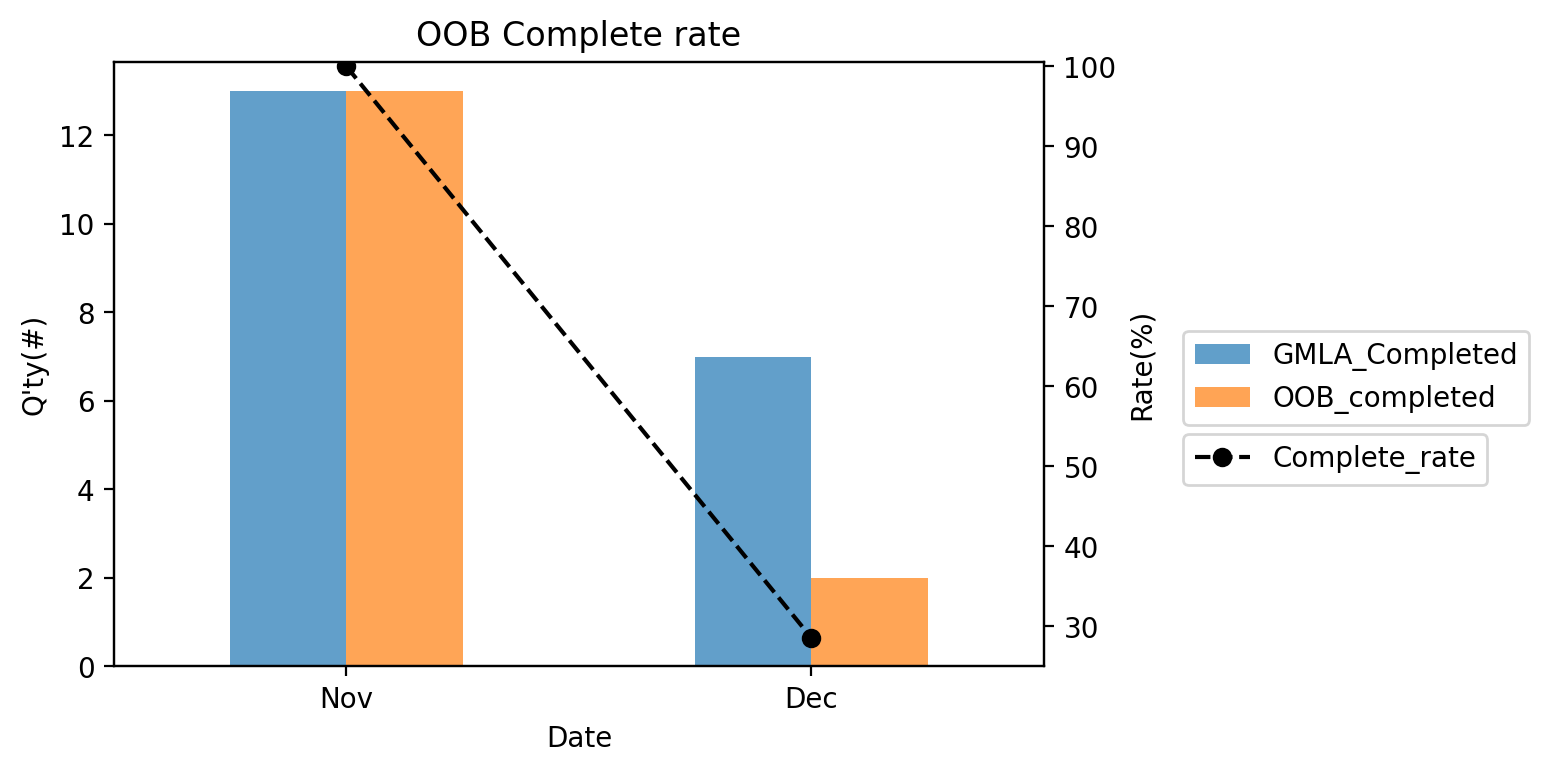

In [43]:
fig, ax1 = plt.subplots(dpi=200)
ax2 = ax1.twinx()

# Barplot for project count
plt.title('OOB Complete rate')
complete[['Project_Name','judgement']].plot.bar(ax=ax1, alpha=0.7)
ax1.set_ylabel("Q'ty(#)")
ax1.set_xlabel('Date')
ax1.legend(['GMLA_Completed','OOB_completed'],loc=(1.15,0.4))

# Lineplot for complete rate
complete['Complete_rate'].plot(ax=ax2, marker='o', color='black', style='--')
ax2.set_ylim(top=100.5)
ax2.set_ylabel("Rate(%)")
ax2.legend(loc=(1.15,0.3))

# Rotate x-ticks
ax1.xaxis.set_tick_params(rotation=0)

# Excel writer

In [44]:
with pd.ExcelWriter('OOB_tracking.xlsx',engine='openpyxl') as writer:
    
    feature_metrix.to_excel(writer, sheet_name='feature_metrix')

    overall_oob_mp_pid.to_excel(writer, sheet_name='overall_oob_mp_pid',index=False)
    auto_adjust_xlsx_column_width(overall_oob_mp_pid, writer, sheet_name="overall_oob_mp_pid", margin=5)

    oob_mp.to_excel(writer, sheet_name='oob_mp',index=False)
    auto_adjust_xlsx_column_width(oob_mp, writer, sheet_name="oob_mp", margin=5)

    oob_pid.to_excel(writer, sheet_name='oob_pid',index=False)
    auto_adjust_xlsx_column_width(oob_pid, writer, sheet_name="oob_pid", margin=5)